In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt
import xgboost as xgb
from tqdm.notebook import tqdm

In [44]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

In [3]:
def smape(y_true, y_pred):
    smap = np.zeros(len(y_true))
    
    num = np.abs(y_true - y_pred)
    dem = ((np.abs(y_true) + np.abs(y_pred)) / 2)
    
    pos_ind = (y_true!=0)|(y_pred!=0)
    smap[pos_ind] = num[pos_ind] / dem[pos_ind]
    
    return 100 * np.mean(smap)

def vsmape(y_true, y_pred):
    smap = np.zeros(len(y_true))
    
    num = np.abs(y_true - y_pred)
    dem = ((np.abs(y_true) + np.abs(y_pred)) / 2)
    
    pos_ind = (y_true!=0)|(y_pred!=0)
    smap[pos_ind] = num[pos_ind] / dem[pos_ind]
    
    return 100 * smap

In [5]:
BASE = '../input/'

In [6]:
df_census = pd.read_csv(BASE + 'census_starter.csv')
df_train = pd.read_csv(BASE + 'train.csv')
df_test = pd.read_csv(BASE + 'test.csv')

In [7]:
df_train['istest'] = 0
df_test['istest'] = 1
df_raw = pd.concat((df_train, df_test)).sort_values(['cfips','row_id']).reset_index(drop=True)

In [8]:
df_raw['first_day_of_month'] = pd.to_datetime(df_raw["first_day_of_month"])
df_raw['county'] = df_raw.groupby('cfips')['county'].ffill()
df_raw['state'] = df_raw.groupby('cfips')['state'].ffill()
df_raw["year"] = df_raw["first_day_of_month"].dt.year
df_raw["month"] = df_raw["first_day_of_month"].dt.month
df_raw["dcount"] = df_raw.groupby(['cfips'])['row_id'].cumcount()
df_raw['county_i'] = (df_raw['county'] + df_raw['state']).factorize()[0]
df_raw['state_i'] = df_raw['state'].factorize()[0]

df_raw['microbusiness_density_bk'] = df_raw['microbusiness_density']

In [9]:
outliers = []
cnt = 0
for o in tqdm(df_raw.cfips.unique()):
    indices = (df_raw['cfips']==o)
    tmp = df_raw.loc[indices].copy().reset_index(drop=True)
    var = tmp.microbusiness_density.values.copy()
    #vmax = np.max(var[:38]) - np.min(var[:38])
    
    for i in range(37, 2, -1):
        thr = 0.20*np.mean(var[:i])
        difa = abs(var[i]-var[i-1])
        if (difa>=thr):
            var[:i] *= (var[i]/var[i-1])
            outliers.append(o)
            cnt+=1
    var[0] = var[1]*0.99
    df_raw.loc[indices, 'microbusiness_density'] = var
    
outliers = np.unique(outliers)
len(outliers), cnt

  0%|          | 0/3135 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  del sys.path[0]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in multiply
  del sys.path[0]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


(481, 732)

<AxesSubplot:xlabel='dcount'>

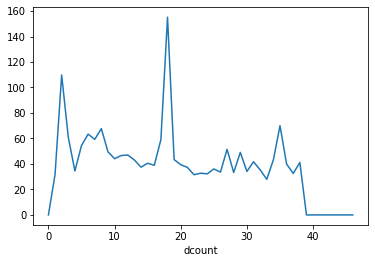

In [10]:
lag = 1
df_raw[f'mbd_lag_{lag}'] = df_raw.groupby('cfips')['microbusiness_density'].shift(lag).bfill()
df_raw['dif'] = (df_raw['microbusiness_density'] / df_raw[f'mbd_lag_{lag}']).fillna(1).clip(0, None) - 1
df_raw.loc[(df_raw[f'mbd_lag_{lag}']==0), 'dif'] = 0
df_raw.loc[(df_raw[f'microbusiness_density']>0) & (df_raw[f'mbd_lag_{lag}']==0), 'dif'] = 1
df_raw['dif'] = df_raw['dif'].abs()
df_raw.groupby('dcount')['dif'].sum().plot()

In [11]:
df_raw['target'] = df_raw.groupby('cfips')['microbusiness_density'].shift(-1)
df_raw['target'] = df_raw['target']/df_raw['microbusiness_density'] - 1

df_raw.loc[df_raw['cfips']==28055, 'target'] = 0.0
df_raw.loc[df_raw['cfips']==48269, 'target'] = 0.0

<AxesSubplot:>

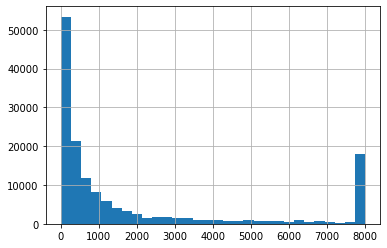

In [12]:
df_raw['lastactive'] = df_raw.groupby('cfips')['active'].transform('last')

dt = df_raw.loc[df_raw.dcount==28].groupby('cfips')['microbusiness_density'].agg('last')
df_raw['lasttarget'] = df_raw['cfips'].map(dt)

df_raw['lastactive'].clip(0, 8000).hist(bins=30)

In [45]:
df_raw.head()

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,istest,year,month,dcount,county_i,state_i,microbusiness_density_bk,mbd_lag_1,dif,target,lastactive,lasttarget,act_lag_1,mbd_lag_2,act_lag_2,mbd_lag_3,act_lag_3,mbd_rollmea2_1,mbd_rollmea4_1,mbd_rollmea6_1,ypred_last,ypred,k,error,error_last
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,2.856021,1249.0,0,2019,8,0,0,0,3.007682,NaN,0.000000,0.010101,1472.0,3.286307,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198.0,0,2019,9,1,0,0,2.884870,0.010101,0.010101,0.059265,1472.0,3.286307,-51.0,NaN,NaN,NaN,NaN,0.010101,0.010101,0.010101,NaN,NaN,1.0,NaN,NaN
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269.0,0,2019,10,2,0,0,3.055843,0.059265,0.059265,-0.020489,1472.0,3.286307,71.0,0.010101,20.0,NaN,NaN,0.069366,0.069366,0.069366,NaN,NaN,1.0,NaN,NaN
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243.0,0,2019,11,3,0,0,2.993233,-0.020489,0.020489,0.000000,1472.0,3.286307,-26.0,0.059265,45.0,0.010101,-6.0,0.038777,0.048878,0.048878,NaN,NaN,1.0,NaN,NaN
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243.0,0,2019,12,4,0,0,2.993233,0.000000,0.000000,-0.008066,1472.0,3.286307,0.0,-0.020489,-26.0,0.059265,45.0,-0.020489,0.048878,0.048878,NaN,NaN,1.0,NaN,NaN


In [13]:
def build_features(df_raw, target='microbusiness_density', target_act='active_tmp', lags = 6):
    feats = []
    for lag in range(1, lags):
        df_raw[f'mbd_lag_{lag}'] = df_raw.groupby('cfips')[target].shift(lag)
        df_raw[f'act_lag_{lag}'] = df_raw.groupby('cfips')[target_act].diff(lag)
        feats.append(f'mbd_lag_{lag}')
        feats.append(f'act_lag_{lag}')
        
    lag = 1
    for window in [2, 4, 6]:
        df_raw[f'mbd_rollmea{window}_{lag}'] = df_raw.groupby('cfips')[f'mbd_lag_{lag}'].transform(lambda s: s.rolling(window, min_periods=1).sum())        
        #df_raw[f'mbd_rollmea{window}_{lag}'] = df_raw[f'mbd_lag_{lag}'] - df_raw[f'mbd_rollmea{window}_{lag}']
        feats.append(f'mbd_rollmea{window}_{lag}')
        
    return df_raw, feats

In [14]:
df_raw, feats = build_features(df_raw, 'target', 'active', lags = 4)
features = ['state_i']
features += feats
print(features)
df_raw.loc[df_raw.dcount==38, features].head(10)

['state_i', 'mbd_lag_1', 'act_lag_1', 'mbd_lag_2', 'act_lag_2', 'mbd_lag_3', 'act_lag_3', 'mbd_rollmea2_1', 'mbd_rollmea4_1', 'mbd_rollmea6_1']


,state_i,mbd_lag_1,act_lag_1,mbd_lag_2,act_lag_2,mbd_lag_3,act_lag_3,mbd_rollmea2_1,mbd_rollmea4_1,mbd_rollmea6_1
38,0,0.006152,9.0,0.005498,17.0,-0.004107,11.0,0.011650,0.034969,0.027467
85,0,0.002170,31.0,-0.017601,-225.0,-0.009601,-366.0,-0.015431,-0.017278,0.049618
132,0,0.020921,5.0,0.008439,7.0,-0.016597,3.0,0.029359,0.033948,0.033966
179,0,-0.021367,-5.0,0.017391,-1.0,-0.025424,-7.0,-0.003976,0.010248,0.028286
226,0,-0.010949,-9.0,0.008589,-2.0,0.002460,0.0,-0.002360,0.033137,0.038372
273,0,0.012987,1.0,0.013158,2.0,0.013333,3.0,0.026145,0.052992,0.080770
320,0,0.009036,3.0,0.027864,12.0,0.031949,22.0,0.036900,0.098454,0.171279
367,0,-0.003180,-8.0,0.007609,11.0,0.002006,16.0,0.004429,0.027747,0.034010
414,0,-0.040201,-16.0,-0.012407,-21.0,-0.017073,-28.0,-0.052608,-0.015697,-0.023285
461,0,-0.012605,-3.0,0.000000,-3.0,-0.008333,-5.0,-0.012605,0.000338,-0.098884


In [15]:
# blacklist = [
#     'North Dakota', 'Iowa', 'Kansas', 'Nebraska', 'South Dakota','New Mexico', 'Alaska', 'Vermont'
# ]
# blacklistcfips = [
# 1019,1027,1029,1035,1039,1045,1049,1057,1067,1071,1077,1085,1091,1099,1101,1123,1131,1133,4001,4012,4013,4021,4023,5001,5003,5005,5017,5019,5027,5031,5035,5047,5063,5065,5071,5081,5083,5087,5091,5093,5107,5109,5115,5121,5137,5139,5141,5147,6003,6015,6027,6033,6053,6055,6057,6071,6093,6097,6103,6105,6115,8003,8007,8009,8019,8021,8023,8047,8051,8053,8055,8057,8059,8061,8065,8067,8069,8071,8073,8075,8085,8091,8093,8097,8099,8103,8105,8107,8109,8111,8115,8117,8121,9007,9009,9015,12009,12017,12019,12029,12047,12055,12065,12075,12093,12107,12127,13005,13007,13015,13017,13019,13027,13035,13047,13065,13081,13083,13099,13107,13109,13117,13119,13121,13123,13125,13127,13135,13143,13147,13161,13165,13171,13175,13181,13193,13201,13221,13225,13229,13231,13233,13245,13247,13249,13257,13279,13281,13287,13289,13293,13301,13319,15001,15005,15007,16001,16003,16005,16007,16013,16015,16017,16023,16025,16029,16031,16033,16035,16037,16043,16045,16049,16061,16063,16067,17001,17003,17007,17009,17013,17015,17023,17025,17031,17035,17045,17051,17059,17061,17063,17065,17067,17069,17075,17077,17081,17085,17087,17103,17105,17107,17109,17115,17117,17123,17127,17133,17137,17141,17143,17147,17153,17167,17169,17171,17177,17179,17181,17185,17187,17193,18001,18007,18009,18013,18015,18019,18021,18025,18035,18037,18039,18041,18053,18061,18075,18079,18083,18087,18099,18103,18111,18113,18115,18137,18139,18145,18153,18171,18179,21001,21003,21013,21017,21023,21029,21035,21037,21039,21045,21047,21055,21059,21065,21075,21077,21085,21091,21093,21097,21099,21101,21103,21115,21125,21137,21139,21141,21149,21155,21157,21161,21165,21179,21183,21191,21197,21199,21215,21217,21223,21227,21237,21239,22019,22021,22031,22039,22041,22047,22069,22085,22089,22101,22103,22109,22111,22115,22119,22121,23003,23009,23021,23027,23029,24011,24027,24029,24031,24035,24037,24039,24041,25011,25015,26003,26007,26011,26019,26021,26025,26027,26033,26037,26041,26043,26051,26053,26057,26059,26061,26065,26071,26077,26079,26083,26089,26097,26101,26103,26109,26111,26115,26117,26119,26127,26129,26131,26135,26141,26143,26155,26161,26165,27005,27011,27013,27015,27017,27021,27023,27025,27029,27047,27051,27055,27057,27065,27069,27073,27075,27077,27079,27087,27091,27095,27101,27103,27105,27107,27109,27113,27117,27119,27123,27125,27129,27131,27133,27135,27141,27147,27149,27155,27159,27167,27169,28017,28019,28023,28025,28035,28045,28049,28061,28063,28093,28097,28099,28125,28137,28139,28147,28159,29001,29015,29019,29031,29033,29041,29049,29051,29055,29057,29063,29065,29069,29075,29085,29089,29101,29103,29111,29121,29123,29125,29135,29137,29139,29143,29157,29159,29161,29167,29171,29173,29175,29177,29183,29195,29197,29199,29203,29205,29207,29209,29213,29215,29217,29223,29227,29229,30005,30009,30025,30027,30033,30035,30037,30039,30045,30049,30051,30053,30055,30057,30059,30069,30071,30073,30077,30079,30083,30085,30089,30091,30093,30101,30103,30105,30107,30109,32005,32009,32017,32023,32027,32029,32510,33005,33007,34021,34027,34033,34035,36011,36017,36023,36033,36043,36047,36049,36051,36057,36061,36067,36083,36091,36097,36103,36107,36113,36115,36121,36123,37005,37009,37011,37017,37023,37029,37031,37049,37061,37075,37095,37117,37123,37131,37137,37151,37187,37189,37197,39005,39009,39015,39017,39019,39023,39037,39039,39043,39049,39053,39057,39063,39067,39071,39077,39085,39087,39091,39097,39105,39107,39113,39117,39119,39125,39127,39129,39135,39137,39151,39153,39157,40003,40013,40015,40023,40025,40027,40035,40039,40043,40045,40053,40055,40057,40059,40065,40067,40073,40077,40079,40099,40105,40107,40111,40115,40123,40127,40129,40133,40141,40147,40151,40153,41001,41007,41013,41015,41017,41021,41025,41031,41033,41037,41051,41055,41063,41067,41069,42005,42007,42011,42013,42015,42019,42027,42029,42031,42035,42053,42057,42067,42071,42083,42085,42093,42097,42105,42111,42113,42115,42123,42125,42127,42129,44005,44007,44009,45001,45009,45021,45025,45031,45059,45067,45071,45073,45089,47001,47005,47013,47015,47019,47021,47023,47027,47035,47039,47041,47047,47055,47057,47059,47061,47069,47073,47075,47077,47083,47087,47099,47105,47121,47127,47131,47133,47135,47137,47147,47151,47153,47159,47161,47163,47169,47177,47183,47185,48001,48011,48017,48019,48045,48057,48059,48063,48065,48073,48077,48079,48081,48083,48087,48095,48101,48103,48107,48109,48115,48117,48119,48123,48125,48129,48149,48151,48153,48155,48159,48161,48165,48175,48189,48191,48195,48197,48211,48221,48229,48233,48235,48237,48239,48241,48243,48245,48255,48261,48263,48265,48267,48269,48275,48277,48283,48293,48299,48305,48311,48313,48319,48321,48323,48327,48333,48345,48347,48355,48369,48377,48379,48383,48387,48389,48401,48403,48413,48417,48431,48433,48437,48443,48447,48453,48455,48457,48461,48463,48465,48469,48471,48481,48483,48485,48487,48495,48499,49001,49009,49013,49019,49027,49031,49045,51005,51017,51025,51029,51031,51036,51037,51043,51057,51059,51065,51071,51073,51077,51079,51083,51091,51095,51097,51101,51111,51115,51119,51121,51127,51135,51147,51155,51159,51165,51167,51171,51173,51181,51183,51191,51197,51530,51590,51610,51620,51670,51678,51720,51735,51750,51770,51810,51820,53013,53019,53023,53031,53033,53037,53039,53041,53047,53065,53069,53071,53075,54013,54019,54025,54031,54033,54041,54049,54055,54057,54063,54067,54071,54077,54079,54085,54089,54103,55001,55003,55005,55007,55011,55017,55021,55025,55029,55037,55043,55047,55049,55051,55061,55065,55067,55075,55077,55091,55097,55101,55103,55109,55117,55123,55125,55127,56007,56009,56011,56015,56017,56019,56021,56027,56031,56037,56043,56045,
# 12061,  6095, 49025, 18073, 29029, 29097, 48419, 51830, 30067, 26095, 18159, 32001, 54065, 54027, 13043, 48177, 55069, 48137, 30087, 29007, 13055, 48295, 28157, 29037, 45061, 22053, 13199, 47171, 53001, 55041, 51195, 18127, 29151, 48307, 51009, 16047, 29133,  5145, 17175, 21027, 48357, 29179, 13023, 16077, 48371, 21057, 16039, 21143, 48435, 48317, 48475,  5129, 36041, 48075, 29017, 47175, 39167, 47109, 17189, 17173, 28009, 39027, 48133, 18129, 48217, 40081, 36021,  6005, 42099, 18051, 36055, 53051, 6109, 21073, 27019,  6051, 48055,  8083, 48503, 17021, 10003, 41061, 22001, 22011, 21205, 48223, 51103, 51047, 16069, 17033, 41011,  6035, 47145, 27083, 18165, 36055, 12001, 26159,  8125, 34017,
# 28141, 55119, 48405, 40029, 18125, 21135, 29073, 55115, 37149,55039, 26029, 12099, 13251, 48421, 39007, 41043, 22015, 37115,54099, 51137, 22049, 55131, 17159, 56001, 40005, 18017, 28091,47101, 27037, 29005, 13239, 21019, 55085, 48253, 51139, 40101,13283, 18049, 39163, 45049, 51113,
# ]

blacklist = []
blacklistcfips = []

In [16]:
# threshold
ACT_THR = 1.8
ABS_THR = 1.0

# define 3 new columns for use
df_raw['ypred_last'] = np.nan
df_raw['ypred'] = np.nan
df_raw['k'] = 1.

VAL = []
BEST_ROUNDS = []

In [17]:
for TS in range(29, 38):
    print(TS)
    
    model = xgb.XGBRegressor(
        objective='reg:pseudohubererror',
        #objective='reg:squarederror',
        tree_method="hist",
        n_estimators=4999,
        learning_rate=0.0075,
        max_leaves = 17,
        subsample=0.50,
        colsample_bytree=0.50,
        max_bin=4096,
        n_jobs=2,
        eval_metric='mae',
        early_stopping_rounds=70,
    )
            
    train_indices = (df_raw.istest==0) & (df_raw.dcount  < TS) & (df_raw.dcount >= 1) & (df_raw.lastactive>ACT_THR)  & (df_raw.lasttarget>ABS_THR) 
    valid_indices = (df_raw.istest==0) & (df_raw.dcount == TS)
    model.fit(
        df_raw.loc[train_indices, features],
        df_raw.loc[train_indices, 'target'].clip(-0.0043, 0.0045),
        eval_set=[(df_raw.loc[valid_indices, features], df_raw.loc[valid_indices, 'target'])],
        verbose=500,
    )
    best_rounds = model.best_iteration
    BEST_ROUNDS.append(model.best_iteration)
    ypred = model.predict(df_raw.loc[valid_indices, features])
    df_raw.loc[valid_indices, 'k'] = ypred + 1
    df_raw.loc[valid_indices,'k'] = df_raw.loc[valid_indices,'k'] * df_raw.loc[valid_indices,'microbusiness_density']

    # Validate
    lastval = df_raw.loc[df_raw.dcount==TS, ['cfips', 'microbusiness_density']].set_index('cfips').to_dict()['microbusiness_density']
    dt = df_raw.loc[df_raw.dcount==TS, ['cfips', 'k']].set_index('cfips').to_dict()['k']
    
    df = df_raw.loc[df_raw.dcount==(TS+1), ['cfips', 'microbusiness_density', 'state', 'lastactive', 'mbd_lag_1']].reset_index(drop=True)
    df['pred'] = df['cfips'].map(dt)
    df['lastval'] = df['cfips'].map(lastval)
    
    df.loc[df['lastactive']<=ACT_THR, 'pred'] = df.loc[df['lastactive']<=ACT_THR, 'lastval']
    df.loc[df['lastval']<=ABS_THR, 'pred'] = df.loc[df['lastval']<=ABS_THR, 'lastval']
    df.loc[df['state'].isin(blacklist), 'pred'] = df.loc[df['state'].isin(blacklist), 'lastval']
    df.loc[df['cfips'].isin(blacklistcfips), 'pred'] = df.loc[df['cfips'].isin(blacklistcfips), 'lastval']
    df_raw.loc[df_raw.dcount==(TS+1), 'ypred'] = df['pred'].values
    df_raw.loc[df_raw.dcount==(TS+1), 'ypred_last'] = df['lastval'].values
    
    print(f'TS: {TS}')
    print('Last Value SMAPE:', smape(df['microbusiness_density'], df['lastval']) )
    print('XGB SMAPE:', smape(df['microbusiness_density'], df['pred']))
    print()


ind = (df_raw.dcount>=30)&(df_raw.dcount<=38)
print( 'XGB SMAPE:', smape( df_raw.loc[ind, 'microbusiness_density'],  df_raw.loc[ind, 'ypred'] ) )
print( 'Last Value SMAPE:', smape( df_raw.loc[ind, 'microbusiness_density'],  df_raw.loc[ind, 'ypred_last'] ) )

29
[0]	validation_0-mae:0.49351
[500]	validation_0-mae:0.01429
[897]	validation_0-mae:0.01090
TS: 29
Last Value SMAPE: 1.0868726017655663
XGB SMAPE: 1.0855474486850072

30
[0]	validation_0-mae:0.48746
[500]	validation_0-mae:0.01257
[641]	validation_0-mae:0.01206
TS: 30
Last Value SMAPE: 1.318087470449913
XGB SMAPE: 1.1648707597209662

31
[0]	validation_0-mae:0.49315
[500]	validation_0-mae:0.01466
[938]	validation_0-mae:0.01117
TS: 31
Last Value SMAPE: 1.1258309832479911
XGB SMAPE: 1.1121862648813519

32
[0]	validation_0-mae:0.49995
[500]	validation_0-mae:0.01701
[1000]	validation_0-mae:0.00928
[1500]	validation_0-mae:0.00912
[1897]	validation_0-mae:0.00911
TS: 32
Last Value SMAPE: 0.897969439640235
XGB SMAPE: 0.916213296716703

33
[0]	validation_0-mae:0.48932
[500]	validation_0-mae:0.01449
[679]	validation_0-mae:0.01329
TS: 33
Last Value SMAPE: 1.3686285670946152
XGB SMAPE: 1.2978448529411128

34
[0]	validation_0-mae:0.47751
[500]	validation_0-mae:0.01611
[511]	validation_0-mae:0.01643

In [19]:
df_raw['error'] = vsmape(df_raw['microbusiness_density'], df_raw['ypred'])
df_raw['error_last'] = vsmape(df_raw['microbusiness_density'], df_raw['ypred_last'])
df_raw.loc[(df_raw.dcount==30), ['cfips', 'microbusiness_density', 'ypred', 'ypred_last','error', 'error_last'] ].head(10)

,cfips,microbusiness_density,ypred,ypred_last,error,error_last
30,1001,3.334431,3.301336,3.296781,0.997481,1.135557
77,1003,7.823300,7.737604,7.733397,1.101431,1.155810
124,1005,1.206827,1.187828,1.186629,1.586785,1.687769
171,1007,1.236650,1.215899,1.214165,1.692156,1.834867
218,1009,1.777708,1.754288,1.752923,1.326149,1.403959
265,1011,0.874082,0.848746,0.848746,2.941173,2.941173
312,1013,1.944535,1.979199,1.977162,1.766905,1.663897
359,1015,2.706717,2.703981,2.701134,0.101116,0.206478
406,1017,1.438767,1.413848,1.412333,1.747103,1.854301
453,1019,1.326550,1.194357,1.193420,10.487745,10.566032


In [20]:
dt = df_raw.loc[(df_raw.dcount>=30)&(df_raw.dcount<=38) ].groupby('state')['error', 'error_last'].mean()
dt['hit'] = dt['error'] - dt['error_last']
dt = dt.sort_values('hit', ascending=True)
dt.iloc[-10:,:]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,error,error_last,hit
state,,,
Montana,1.394307,1.455042,-0.060735
Iowa,1.174762,1.225780,-0.051018
Nevada,1.598844,1.643848,-0.045004
New Mexico,1.243064,1.275656,-0.032592
Kansas,1.425847,1.432441,-0.006594
North Dakota,1.654585,1.656041,-0.001456
Nebraska,1.453896,1.452507,0.001388
Vermont,0.959955,0.951296,0.008658
Alaska,1.451936,1.438772,0.013164


In [26]:
dt = df_raw.loc[(df_raw.dcount>=30)&(df_raw.dcount<=38) ].groupby('cfips')['error', 'error_last'].mean()
dt['hit'] = dt['error'] - dt['error_last']
dt = dt.sort_values('hit', ascending=False)
dt = dt.loc[dt['hit']>0.00]
dt.iloc[-10:,:]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,error,error_last,hit
cfips,,,
31069,2.340448,2.339180,0.001268
17147,0.516579,0.515494,0.001085
21037,0.335446,0.334467,0.000978
13213,0.878015,0.877108,0.000907
27019,0.401042,0.400635,0.000407
42067,1.071352,1.071006,0.000345
47021,0.466823,0.466502,0.000321
46055,2.116306,2.115987,0.000319
20111,0.587015,0.586891,0.000124


In [34]:
dt = df_raw.loc[(df_raw.dcount>=30)&(df_raw.dcount<=38) ].groupby(['cfips','dcount'])['error', 'error_last'].last()
dt['miss'] = dt['error'] > dt['error_last']
dt

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


error  error_last   miss
cfips dcount                             
1001  30      0.997481    1.135557  False
      31      0.565290    0.070548   True
      32      0.970114    1.052261  False
      33      1.811295    1.759945   True
      34      0.583175    0.989406  False
...                ...         ...    ...
56045 34      0.458107    0.000000   True
      35      1.608222    0.000000   True
      36      1.021190    0.995027   True
      37      0.195943    0.000000   True
      38      0.132806    0.000000   True

[28215 rows x 3 columns]

In [35]:
dt = dt.groupby('cfips')['miss'].mean()
dt

cfips
1001     0.333333
1003     0.444444
1005     0.444444
1007     0.444444
1009     0.333333
           ...   
56037    0.555556
56039    0.444444
56041    0.111111
56043    0.777778
56045    0.888889
Name: miss, Length: 3135, dtype: float64

In [36]:
dt = dt.loc[dt>=0.50]
dt.index
blacklist = ','.join([str(i) for i in dt.index])
len(blacklist)

7338

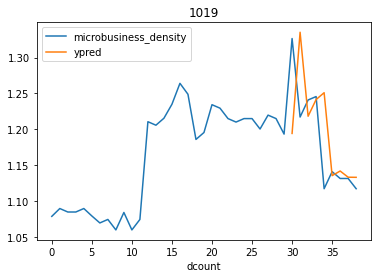

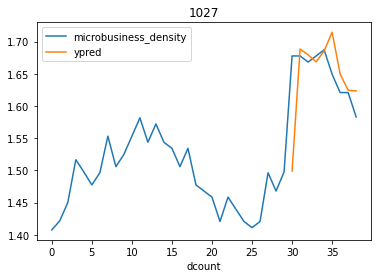

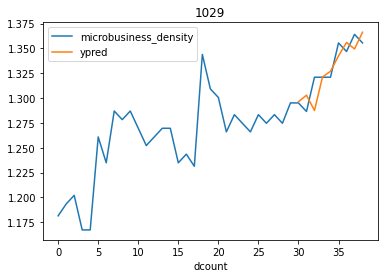

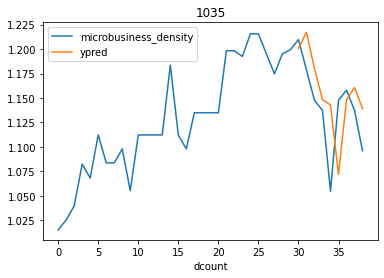

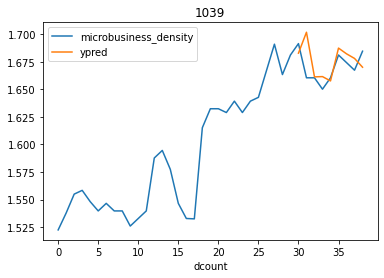

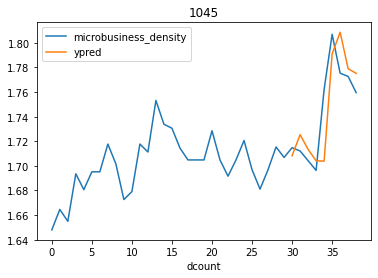

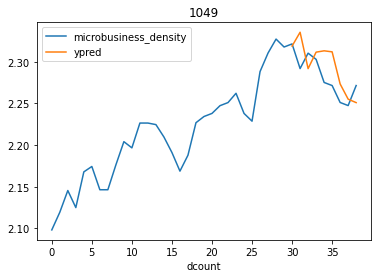

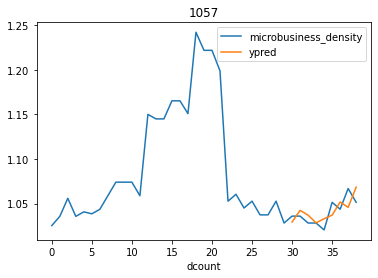

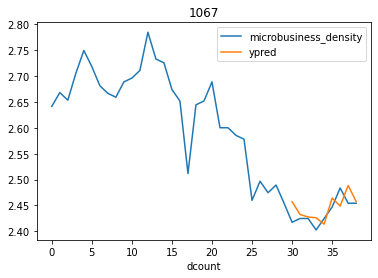

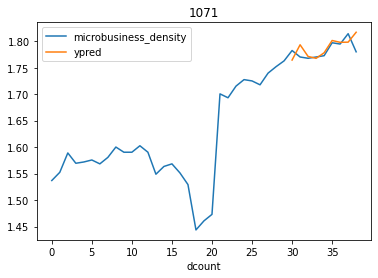

In [31]:
for d in dt.index[:10]:
    df_raw.loc[df_raw.cfips==d].plot(x='dcount', y=['microbusiness_density', 'ypred'], title=str(d))
    #raw.loc[raw.cfips==d].plot(x='dcount', y=['microbusiness_density', 'ypred_last'], title=str(d))